## **Abstract**
In this project, we use an Alternating Lease Squares (ALS) algorithm with Spark APIs to predict the rating for movies. 

### Spark Setup 

In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.forsale.plus/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!ls
!tar xf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install py4j

!export JAVA_HOME=$(/usr/lib/jvm/java-8-openjdk-amd64 -v 1.8)
! echo $JAVA_HOME


In [2]:
!wget -q http://apache.mirrors.pair.com/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz


In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.2-bin-hadoop2.7"

import findspark
findspark.init("spark-3.0.2-bin-hadoop2.7")# SPARK_HOME

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

from pyspark.sql.types import *
from pyspark.sql.functions import col, mean, udf, lit, current_timestamp, unix_timestamp, array_contains

In [4]:
!ls

sample_data  spark-3.0.2-bin-hadoop2.7	spark-3.0.2-bin-hadoop2.7.tgz


In [5]:
spark.version

'3.0.2'

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline
import re

## **Part 0: Data ETL**

* This notebook uses the "small" version of the latest MovieLens movie rating dataset, containing about 100,000 ratings, 9,000 movies and 800 users. \\
* The latest version of the data can be downloaded at https://grouplens.org/datasets/movielens/latest/




In [7]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving links.csv to links.csv
Saving movies.csv to movies.csv
Saving ratings.csv to ratings.csv
Saving tags.csv to tags.csv
User uploaded file "links.csv" with length 197979 bytes
User uploaded file "movies.csv" with length 494431 bytes
User uploaded file "ratings.csv" with length 2483723 bytes
User uploaded file "tags.csv" with length 118660 bytes


In [8]:
movies_df = spark.read.load("movies.csv",format='csv', header=True)
ratings_df = spark.read.load("ratings.csv", format='csv', header = True)
links_df = spark.read.load("links.csv", format='csv', header = True)
tags_df = spark.read.load("tags.csv", format='csv', header = True)

In [9]:
ratings_df.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [10]:
movies_df.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [11]:
links_df.show(5)

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
|      2|0113497|  8844|
|      3|0113228| 15602|
|      4|0114885| 31357|
|      5|0113041| 11862|
+-------+-------+------+
only showing top 5 rows



In [12]:
tags_df.show(5)

+------+-------+---------------+----------+
|userId|movieId|            tag| timestamp|
+------+-------+---------------+----------+
|     2|  60756|          funny|1445714994|
|     2|  60756|Highly quotable|1445714996|
|     2|  60756|   will ferrell|1445714992|
|     2|  89774|   Boxing story|1445715207|
|     2|  89774|            MMA|1445715200|
+------+-------+---------------+----------+
only showing top 5 rows



In [13]:
tmp1 = ratings_df.groupBy('UserId').count().toPandas()['count'].min()
tmp2 = ratings_df.groupBy('movieId').count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1


In [14]:
temp1 = sum(ratings_df.groupBy('movieId').count().toPandas()['count'] == 1)
temp2 = ratings_df.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(temp1,temp2))

3446 out of 9724 movies are rated by only one user


## **Part 1: Spark SQL and OLAP**


In [15]:
movies_df.registerTempTable("movies")
ratings_df.registerTempTable("ratings")
links_df.registerTempTable("links")
tags_df.registerTempTable("tags")

### Q1: Number of Movies

In [16]:
movies_df.select('movieID').distinct().count()

9742

### Q2: Number of Users


In [17]:
spark.sql("select count(distinct userId) as Num_of_Users from ratings").show()

+------------+
|Num_of_Users|
+------------+
|         610|
+------------+



### Q3: How many movies are rated by users? List movies not rated before

In [18]:
spark.sql("select count(distinct movieId) as Num_of_Rated_Movies from ratings").show()

+-------------------+
|Num_of_Rated_Movies|
+-------------------+
|               9724|
+-------------------+



In [19]:
# Movies not rated before
spark.sql("select movieId, title from movies where movieId not in (select movieId from ratings)").show()

+-------+--------------------+
|movieId|               title|
+-------+--------------------+
|   1076|Innocents, The (1...|
|   2939|      Niagara (1953)|
|   3338|For All Mankind (...|
|   3456|Color of Paradise...|
|   4194|I Know Where I'm ...|
|   5721|  Chosen, The (1981)|
|   6668|Road Home, The (W...|
|   6849|      Scrooge (1970)|
|   7020|        Proof (1991)|
|   7792|Parallax View, Th...|
|   8765|This Gun for Hire...|
|  25855|Roaring Twenties,...|
|  26085|Mutiny on the Bou...|
|  30892|In the Realms of ...|
|  32160|Twentieth Century...|
|  32371|Call Northside 77...|
|  34482|Browning Version,...|
|  85565|  Chalet Girl (2011)|
+-------+--------------------+



### Q4: List Movie Genres

In [20]:
spark.sql("select distinct explode(split (genres, '[|]')) as genres from movies order by 1").show()

+------------------+
|            genres|
+------------------+
|(no genres listed)|
|            Action|
|         Adventure|
|         Animation|
|          Children|
|            Comedy|
|             Crime|
|       Documentary|
|             Drama|
|           Fantasy|
|         Film-Noir|
|            Horror|
|              IMAX|
|           Musical|
|           Mystery|
|           Romance|
|            Sci-Fi|
|          Thriller|
|               War|
|           Western|
+------------------+



In [21]:
spark.sql("select movieId, title, explode(split (genres, '[|]')) as genres from movies").show()

+-------+--------------------+---------+
|movieId|               title|   genres|
+-------+--------------------+---------+
|      1|    Toy Story (1995)|Adventure|
|      1|    Toy Story (1995)|Animation|
|      1|    Toy Story (1995)| Children|
|      1|    Toy Story (1995)|   Comedy|
|      1|    Toy Story (1995)|  Fantasy|
|      2|      Jumanji (1995)|Adventure|
|      2|      Jumanji (1995)| Children|
|      2|      Jumanji (1995)|  Fantasy|
|      3|Grumpier Old Men ...|   Comedy|
|      3|Grumpier Old Men ...|  Romance|
|      4|Waiting to Exhale...|   Comedy|
|      4|Waiting to Exhale...|    Drama|
|      4|Waiting to Exhale...|  Romance|
|      5|Father of the Bri...|   Comedy|
|      6|         Heat (1995)|   Action|
|      6|         Heat (1995)|    Crime|
|      6|         Heat (1995)| Thriller|
|      7|      Sabrina (1995)|   Comedy|
|      7|      Sabrina (1995)|  Romance|
|      8| Tom and Huck (1995)|Adventure|
+-------+--------------------+---------+
only showing top

### Q5: Movies for each genre

In [22]:
#Number of Movies for each genre
spark.sql(
    '''select genres, count(movieId) as Num_of_Movies from 
    (select explode (split(genres, '[|]')) as genres, movieId from movies)
    group by genres
    order by Num_of_Movies desc
    ''').show()

+------------------+-------------+
|            genres|Num_of_Movies|
+------------------+-------------+
|             Drama|         4361|
|            Comedy|         3756|
|          Thriller|         1894|
|            Action|         1828|
|           Romance|         1596|
|         Adventure|         1263|
|             Crime|         1199|
|            Sci-Fi|          980|
|            Horror|          978|
|           Fantasy|          779|
|          Children|          664|
|         Animation|          611|
|           Mystery|          573|
|       Documentary|          440|
|               War|          382|
|           Musical|          334|
|           Western|          167|
|              IMAX|          158|
|         Film-Noir|           87|
|(no genres listed)|           34|
+------------------+-------------+



In [23]:
# List of movies for each genre
spark.sql(
  '''select genres, concat_ws(',',collect_set(title)) as list_of_movies from
  (select explode(split(genres,'[|]')) as genres, title From movies) group By 1''').show()


+------------------+--------------------+
|            genres|      list_of_movies|
+------------------+--------------------+
|             Crime|Stealing Rembrand...|
|           Romance|Vampire in Brookl...|
|          Thriller|Element of Crime,...|
|         Adventure|Ice Age: Collisio...|
|             Drama|Airport '77 (1977...|
|               War|General, The (192...|
|       Documentary|The Barkley Marat...|
|           Fantasy|Masters of the Un...|
|           Mystery|Before and After ...|
|           Musical|U2: Rattle and Hu...|
|         Animation|Ice Age: Collisio...|
|         Film-Noir|Rififi (Du rififi...|
|(no genres listed)|T2 3-D: Battle Ac...|
|              IMAX|Harry Potter and ...|
|            Horror|Underworld: Rise ...|
|           Western|Man Who Shot Libe...|
|            Comedy|Hysteria (2011),H...|
|          Children|Ice Age: Collisio...|
|            Action|Stealing Rembrand...|
|            Sci-Fi|Push (2009),SORI:...|
+------------------+--------------



## **Part 2: Exploratory Data Analysis (EDA)**

### **Ratings**

In [24]:
# Distribution of rating by catogeries
ratings_df.groupBy('rating').count().toPandas()

,rating,count
0,1.0,2811
1,4.5,8551
2,2.5,5550
3,3.5,13136
4,5.0,13211
5,0.5,1370
6,4.0,26818
7,1.5,1791
8,2.0,7551
9,3.0,20047


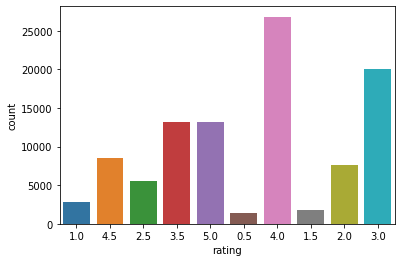

In [25]:
sns.barplot(x='rating', y='count', data=ratings_df.groupBy('rating').count().toPandas())
plt.savefig('fig1.png', dpi=600)

In [26]:
# Distribution of average rating of movies
ratings_df.groupBy('MovieId').agg({"rating":"mean"}).toPandas().head()

,MovieId,avg(rating)
0,296,4.197068
1,1090,3.984127
2,115713,3.910714
3,3210,3.476190
4,88140,3.546875


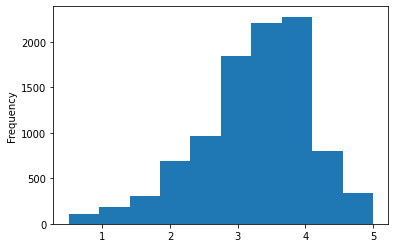

In [27]:
ratings_df.groupBy('MovieId').agg({"rating":"mean"}).toPandas()['avg(rating)'].plot(kind='hist')
plt.savefig('fig2.png')

In [28]:
#average rating from users
ratings_df.groupBy('userID').agg({"rating":"mean"}).toPandas().head()

,userID,avg(rating)
0,296,4.166667
1,467,3.409091
2,125,3.859722
3,451,3.794118
4,7,3.230263


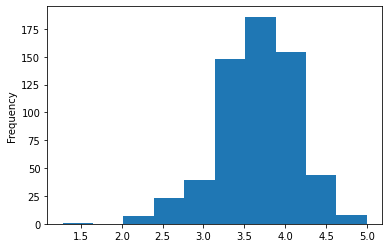

In [29]:
ratings_df.groupBy('userID').agg({"rating":"mean"}).toPandas()['avg(rating)'].plot(kind='hist')
plt.savefig('fig_003.png', dpi=600)

### **Movies**

In [30]:
# define a UDF to convert the raw genres string to an array of genres and lowercase
extract_genres = udf(lambda x: x.lower().split("|"), ArrayType(StringType()))
# test it out
movies_df.select("movieId", "title", extract_genres("genres").alias("genres")).show(5, False)

+-------+----------------------------------+-------------------------------------------------+
|movieId|title                             |genres                                           |
+-------+----------------------------------+-------------------------------------------------+
|1      |Toy Story (1995)                  |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji (1995)                    |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men (1995)           |[comedy, romance]                                |
|4      |Waiting to Exhale (1995)          |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II (1995)|[comedy]                                         |
+-------+----------------------------------+-------------------------------------------------+
only showing top 5 rows



In [31]:
# Next, define a UDF to extract the release year from the title, and return the new title and year in a struct type
def extract_year_fn(title):
    result = re.search("\(\d{4}\)", title)
    try:
        if result:
            group = result.group()
            year = group[1:-1]
            start_pos = result.start()
            title = title[:start_pos-1]
            return (title, year)
        else:
            return (title, 1970)
    except:
        print(title)

extract_year = udf(extract_year_fn,\
                   StructType([StructField("title", StringType(), True),\
                               StructField("release_date", StringType(), True)]))

# test:
s = "Jumanji (1995)"
extract_year_fn(s)

('Jumanji', '1995')

In [32]:
# Now we can create a new dataframe with the cleaned-up titles, release dates and genres of the movies.
movies = movies_df.select('movieId', extract_year('title').title.alias('title'),\
                          extract_year('title').release_date.alias('release_date'),\
                          extract_genres('genres').alias('genres'))
print('Cleaned movie data:')
movies.show(5, truncate=False)

Cleaned movie data:
+-------+---------------------------+------------+-------------------------------------------------+
|movieId|title                      |release_date|genres                                           |
+-------+---------------------------+------------+-------------------------------------------------+
|1      |Toy Story                  |1995        |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji                    |1995        |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men           |1995        |[comedy, romance]                                |
|4      |Waiting to Exhale          |1995        |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II|1995        |[comedy]                                         |
+-------+---------------------------+------------+-------------------------------------------------+
only showing top 5 rows



## **Part 3: Recommender System based on Spark ALS**

### ALS Model Selection and Evaluation
Step1: We use the Alternating Least Squares (ALS) method to train our collaborative filtering model. \\
Step 2: Then we can use a grid search method and 5-fold cross validation to find the optimal hyperparameters and model.
https://spark.apache.org/docs/2.2.0/ml-collaborative-filtering.html



In [33]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder
from pyspark.sql.functions import col, explode
from pyspark import SparkContext

In [34]:
ratings_df.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [35]:
movie_ratings = ratings_df.drop('timestamp')

In [36]:
# Data type convert
from pyspark.sql.types import IntegerType, FloatType
movie_ratings = movie_ratings.withColumn("userId", movie_ratings["userId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("movieId", movie_ratings["movieId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("rating", movie_ratings["rating"].cast(FloatType()))

In [38]:
movie_ratings.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
|     1|     70|   3.0|
|     1|    101|   5.0|
|     1|    110|   4.0|
|     1|    151|   5.0|
|     1|    157|   5.0|
|     1|    163|   5.0|
|     1|    216|   5.0|
|     1|    223|   3.0|
|     1|    231|   5.0|
|     1|    235|   4.0|
|     1|    260|   5.0|
|     1|    296|   3.0|
|     1|    316|   3.0|
|     1|    333|   5.0|
|     1|    349|   4.0|
+------+-------+------+
only showing top 20 rows



In [39]:
(training,test)=movie_ratings.randomSplit([0.8,0.2], seed=2021)

In [40]:
# Create ALS model
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop")

In [41]:
#Tune parameters using ParamGridBuilder
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [5,10,15]) \
            .addGrid(als.regParam, [.01, .05, .1, 0.5,1]) \
            .addGrid(als.maxIter, [1,5,10,20]) \
            .build()

In [42]:
evaluator = RegressionEvaluator(
           metricName="rmse", 
           labelCol="rating", 
           predictionCol="prediction") 
print ("Num models to be tested: ", len(param_grid))

Num models to be tested:  60


In [43]:
# Build Cross validation 
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

In [44]:
#Fit ALS model to training data
model = cv.fit(training)

In [45]:
#Extract best model from the tuning exercise using ParamGridBuilder
best_model = model.bestModel

### Model testing
Make a prediction and check the testing error

In [46]:
predictions=best_model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)

In [47]:
best_model.itemFactors.take(3)


[Row(id=10, features=[-0.6803321838378906, 1.0536303520202637, 0.5431411862373352, 1.223325252532959, 0.5036402344703674]),
 Row(id=20, features=[-0.20297405123710632, 0.002049393253400922, 0.6218985319137573, 1.3872772455215454, 0.06215854361653328]),
 Row(id=30, features=[0.28143182396888733, -0.757163941860199, 1.6056792736053467, 0.8876832127571106, 0.8193959593772888])]

In [48]:
best_model.userFactors.take(3)

[Row(id=10, features=[-1.2579220533370972, 0.49616900086402893, -0.36562177538871765, 1.5312559604644775, -0.49138668179512024]),
 Row(id=20, features=[-0.1411479413509369, -0.22402654588222504, 0.32051968574523926, 2.063145399093628, 0.6851462721824646]),
 Row(id=30, features=[-0.6276765465736389, 0.9084822535514832, 0.22161878645420074, 1.7361475229263306, 0.8384144306182861])]

In [49]:
print ("RMSE = "+str(rmse))
print ("**Best Model**")
print (" Rank:",best_model._java_obj.parent().getRank()), 
print (" MaxIter:", best_model._java_obj.parent().getMaxIter()), 
print (" RegParam:", best_model._java_obj.parent().getRegParam())

#https://stackoverflow.com/questions/36697304/how-to-extract-model-hyper-parameters-from-spark-ml-in-pyspark
#to extract model hyper-parameters from spark.ml in PySpark.

RMSE = 0.8774600150377428
**Best Model**
 Rank: 5
 MaxIter: 20
 RegParam: 0.1


In [50]:
predictions.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   133|    471|   4.0|  2.936203|
|   597|    471|   2.0|  4.202857|
|    91|    471|   1.0| 2.6440616|
|   372|    471|   3.0| 3.4645562|
|   462|    471|   2.5| 2.8448946|
|   273|    471|   5.0| 4.3586736|
|   104|    471|   4.5| 3.7255955|
|   609|    833|   3.0| 1.6654465|
|   463|   1088|   3.5| 3.2195218|
|   159|   1088|   4.0| 3.2641032|
|   606|   1088|   3.0| 3.1884484|
|   132|   1088|   4.0|  2.811763|
|   554|   1088|   5.0|  3.489267|
|   509|   1088|   3.0|  3.241763|
|   226|   1088|   1.0| 3.1586156|
|   188|   1088|   4.0|  3.493246|
|   517|   1088|   1.0|  2.594212|
|   325|   1342|   4.0| 2.6032484|
|    19|   1342|   2.0|  2.012765|
|   593|   1580|   1.5| 2.7268054|
+------+-------+------+----------+
only showing top 20 rows



### Model Apply and see the performance


In [51]:
alldata=best_model.transform(movie_ratings)
rmse = evaluator.evaluate(alldata)
print ("RMSE = "+str(rmse))

RMSE = 0.6879247621562344


In [52]:
alldata.registerTempTable("alldata")

In [53]:
alldata.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   133|    471|   4.0|  2.936203|
|   597|    471|   2.0|  4.202857|
|   385|    471|   4.0| 3.1731503|
|   436|    471|   3.0|  3.555396|
|   602|    471|   4.0| 3.1846871|
|    91|    471|   1.0| 2.6440616|
|   409|    471|   3.0| 3.9559875|
|   372|    471|   3.0| 3.4645562|
|   599|    471|   2.5|  2.928978|
|   603|    471|   4.0| 3.5644493|
|   182|    471|   4.5| 3.6758513|
|   218|    471|   4.0| 3.4209101|
|   474|    471|   3.0| 3.4139369|
|   500|    471|   1.0|  2.357656|
|    57|    471|   3.0| 3.7990675|
|   462|    471|   2.5| 2.8448946|
|   387|    471|   3.0| 3.1810107|
|   610|    471|   4.0| 3.7888393|
|   217|    471|   2.0| 2.5116534|
|   555|    471|   3.0| 3.9256139|
+------+-------+------+----------+
only showing top 20 rows



In [55]:
spark.sql("select * from movies join alldata on movies.movieId = alldata.movieId").show()

+-------+--------------------+------+------+-------+------+----------+
|movieId|               title|genres|userId|movieId|rating|prediction|
+-------+--------------------+------+------+-------+------+----------+
|    471|Hudsucker Proxy, ...|Comedy|   133|    471|   4.0|  2.936203|
|    471|Hudsucker Proxy, ...|Comedy|   597|    471|   2.0|  4.202857|
|    471|Hudsucker Proxy, ...|Comedy|   385|    471|   4.0| 3.1731503|
|    471|Hudsucker Proxy, ...|Comedy|   436|    471|   3.0|  3.555396|
|    471|Hudsucker Proxy, ...|Comedy|   602|    471|   4.0| 3.1846871|
|    471|Hudsucker Proxy, ...|Comedy|    91|    471|   1.0| 2.6440616|
|    471|Hudsucker Proxy, ...|Comedy|   409|    471|   3.0| 3.9559875|
|    471|Hudsucker Proxy, ...|Comedy|   372|    471|   3.0| 3.4645562|
|    471|Hudsucker Proxy, ...|Comedy|   599|    471|   2.5|  2.928978|
|    471|Hudsucker Proxy, ...|Comedy|   603|    471|   4.0| 3.5644493|
|    471|Hudsucker Proxy, ...|Comedy|   182|    471|   4.5| 3.6758513|
|    4

### Recommend movie to users with id 575 and 202

In [56]:
!pip install koalas
import databricks.koalas as ks

     |████████████████████████████████| 675kB 5.1MB/s 


In [70]:
# Generate top 10 movie recommendations for each user
userRecs = best_model.recommendForAllUsers(10)
userRecs_ks=userRecs.to_koalas()
movies_ks=movies.to_koalas()

In [59]:
def movieRecommendation(inputId):
  recs_list=[]
  for recs in userRecs_ks.loc[str(inputId), 'recommendations']:
    recs_list.append(str(recs[0]))
  return (movies_ks[movies_ks['movieId'].isin(recs_list)])

In [71]:
# Recommend movie to users with id 575 and 202
print("Recommended movies for user with id '575' are as follows.")
movieRecommendation(575)

Recommended movies for user with id '575' are as follows.


,movieId,title,release_date,genres
1309,1755,Shooting Fish,1997,"[comedy, romance]"
3685,5075,Waydowntown,2000,[comedy]
4986,7669,Pride and Prejudice,1995,"[drama, romance]"
5867,32892,Ivan's Childhood (a.k.a. My Name is Ivan) (Iva...,1962,"[drama, war]"
6444,51931,Reign Over Me,2007,[drama]
7536,84847,Emma,2009,"[comedy, drama, romance]"
8110,100714,Before Midnight,2013,"[drama, romance]"
8473,112804,I Origins,2014,"[drama, sci-fi]"
9042,141718,Deathgasm,2015,"[comedy, horror]"
9264,156726,Hush,2016,[thriller]


In [72]:
print("Recommended movies for user with id '202' are as follows.")
movieRecommendation(202)

Recommended movies for user with id '202' are as follows.


,movieId,title,release_date,genres
107,123,Chungking Express (Chung Hing sam lam),1994,"[drama, mystery, romance]"
2410,3200,"Last Detail, The",1973,"[comedy, drama]"
2523,3379,On the Beach,1959,[drama]
2665,3567,Bossa Nova,2000,"[comedy, drama, romance]"
3320,4495,Crossing Delancey,1988,"[comedy, romance]"
3905,5485,Tadpole,2002,"[comedy, drama, romance]"
3908,5490,The Big Bus,1976,"[action, comedy]"
4251,6201,Lady Jane,1986,"[drama, romance]"
4358,6375,Gigantic (A Tale of Two Johns),2002,[documentary]
7166,71899,Mary and Max,2009,"[animation, comedy, drama]"


### Find similar movies for a given movie








In [65]:
itemFactors=best_model.itemFactors.to_koalas() 

In [66]:
def similarMovies(inputId, matrix='cosine_similarity'):
  try:
    movieFeature=itemFactors.loc[itemFactors.id==str(inputId),'features'].to_numpy()[0]
  except:
    return 'There is no movie with id ' + str(inputId)
  
  if matrix=='cosine_similarity':
    similarMovie=pd.DataFrame(columns=('movieId','cosine_similarity'))
    for id,feature in itemFactors.to_numpy():
      cs=np.dot(movieFeature,feature)/(np.linalg.norm(movieFeature) * np.linalg.norm(feature))
      similarMovie=similarMovie.append({'movieId':str(id), 'cosine_similarity':cs}, ignore_index=True)
    similarMovie_cs=similarMovie.sort_values(by=['cosine_similarity'],ascending = False)[1:11]
    joint=similarMovie_cs.merge(movies_ks.to_pandas(), left_on='movieId', right_on = 'movieId', how = 'inner')
    
  if matrix=='euclidean_distance':
    similarMovie=pd.DataFrame(columns=('movieId','euclidean_distance'))
    for id,feature in itemFactors.to_numpy():
      ed=np.linalg.norm(np.array(movieFeature)-np.array(feature))
      similarMovie=similarMovie.append({'movieId':str(id), 'euclidean_distance':ed}, ignore_index=True)
    similarMovie_ed=similarMovie.sort_values(by=['euclidean_distance'])[1:11]
    joint=similarMovie_ed.merge(movies_ks.to_pandas(), left_on='movieId', right_on = 'movieId', how = 'inner')
  return joint[['movieId','title','genres']]

In [73]:
# Get similar movies for movie 353
similarMovies(353)

,movieId,title,genres
0,160567,Mike & Dave Need Wedding Dates,[comedy]
1,141544,Turbo Kid,"[action, adventure, sci-fi]"
2,167746,The Lego Batman Movie,"[action, animation, comedy]"
3,127198,Dope,"[comedy, drama]"
4,2288,"Thing, The","[action, horror, sci-fi, thriller]"
5,27006,RKO 281,[drama]
6,27369,Daria: Is It Fall Yet?,"[animation, comedy]"
7,66544,Nuremberg,"[drama, war]"
8,79006,Empire of Dreams: The Story of the 'Star Wars'...,[documentary]
9,76060,"Slammin' Salmon, The",[comedy]


In [74]:
print('Similar movies based on cosine similarity matrix are as follows.')
similarMovies(488, 'cosine_similarity')

Similar movies based on cosine similarity matrix are as follows.


,movieId,title,genres
0,8481,Northwest Passage,"[action, adventure, drama, romance, thriller, ..."
1,8711,Mr. Blandings Builds His Dream House,[comedy]
2,8771,Sherlock Holmes: Terror by Night,"[crime, mystery, thriller]"
3,8955,Undertow,"[crime, drama, thriller]"
4,4521,Little Nikita,[drama]
5,8057,Sweet Bird of Youth,[drama]
6,1941,Hamlet,[drama]
7,8987,Bush's Brain,[documentary]
8,5440,She Wore a Yellow Ribbon,[western]
9,1933,"Life of Emile Zola, The",[drama]


In [75]:
print('Similar movies based on euclidean distance matrix are as follows.')
similarMovies(488, 'euclidean_distance')

Similar movies based on euclidean distance matrix are as follows.


,movieId,title,genres
0,4055,Panic,[drama]
1,6336,Marooned in Iraq (Gomgashtei dar Aragh),[drama]
2,8987,Bush's Brain,[documentary]
3,8712,My Favorite Wife,"[comedy, romance]"
4,7167,Japanese Story,[drama]
5,6225,King of Kings,[drama]
6,2611,"Winslow Boy, The",[drama]
7,2652,"Curse of Frankenstein, The",[horror]
8,8575,"Happenstance (Battement d'ailes du papillon, Le)","[comedy, drama]"
9,7083,Sweet Dreams,[drama]


## **Summary**
**Step 1: Data ETL** \\
I firsly load the data, generate the Spark dataframes, and check the basic information of the dataset. \\
**Step 2: Online Analytical Processing** \\
This part utilizes Spark SQL to perform analysis from multiple angle and generate intuitive insights. \\
**Step 3: Exploratory Data Analysis** \\
I create a dataframe UDF to transform the data into a more readable form. Then I look at the distribution of ratings and movies using seaborn and matplotlib. \\
**Step 4: Model Selection and Evaluation** \\
Using Spark MLlib, I train a a collaborative filtering recommendation model from the ratings data. I tune the hyperparameters using 5-fold cross-validation, apply the optimal parameter set to the model, and evaluate the performance of final model by measuring the root mean square error of rating prediction on the test set. \\
**Step 5: Model Application** \\
I write a function to recommend 10 movies for any particular user. \\
I also apply the prediction results to find similar movies for a given movie. I use two matrix to evaluate the similarity between movies: cosine similarity and euclidean distance, which can be used separately depending on situations.